In [ ]:
!pip install vmdpy

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from vmdpy import VMD  # ⚠️ Cần cài đặt: pip install vmdpy
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Load & Preprocess Data
# ===============================
df = pd.read_csv("full_data_imputed.csv", index_col=False)
df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')

df_copy = df.copy()
df_copy['Local Time'] = pd.to_datetime(df_copy['Local Time'])
df_copy = df_copy.set_index('Local Time')

# Fill missing values
weather_cols = ['Clouds', 'Precipitation', 'Pressure', 'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed']
df_copy[weather_cols] = df_copy[weather_cols].ffill().bfill()

# 🆕 2️⃣ VMD Decomposition (Safe RAM Version)
# ===============================
print("Đang thực hiện VMD Decomposition theo từng đoạn (Chunking)...")

# --- Cấu hình VMD ---
alpha = 2000
tau = 0
K = 9
DC = 0
init = 1
tol = 1e-7

# --- Cấu hình Chunking ---
# Thay vì chạy hết, ta chạy mỗi lần 4000 dòng (~6 tháng dữ liệu/giờ)
# ===============================
# 🛠️ FIX BƯỚC 2: VMD CHUNKING (AN TOÀN)
# ===============================
print("Đang chạy VMD với cơ chế sửa lỗi kích thước...")

CHUNK_SIZE = 4000
signal = df_copy['Aqi'].values
n_samples = len(signal)
vmd_results = np.zeros((n_samples, K), dtype=np.float32)

for i in range(0, n_samples, CHUNK_SIZE):
    end_idx = min(i + CHUNK_SIZE, n_samples)
    chunk_signal = signal[i:end_idx]

    # Bỏ qua nếu chunk quá ngắn gây lỗi hội tụ
    if len(chunk_signal) < 200:
        if i > 0:
            # Copy dòng cuối của chunk trước để lấp đầy
            last_valid_vals = vmd_results[i-1, :]
            # Lặp lại giá trị này cho phần còn thiếu
            fill_len = end_idx - i
            vmd_results[i:end_idx, :] = np.tile(last_valid_vals, (fill_len, 1))
        continue

    try:
        # Chạy VMD
        u, u_hat, omega = VMD(chunk_signal, alpha, tau, K, DC, init, tol)

        # ⚠️ FIX LỖI Ở ĐÂY:
        # u.shape thường là (K, length). Ta lấy length thực tế từ u
        actual_len = u.shape[1]

        # Chỉ gán đúng số lượng phần tử mà VMD trả về
        # Nếu VMD trả về ít hơn 1 phần tử, ta chỉ điền đến i + actual_len
        vmd_results[i : i + actual_len, :] = u.T

        # Nếu thiếu 1 dòng do lỗi FFT (ví dụ input 1433, output 1432)
        # Ta copy dòng cuối cùng của u để bù vào dòng thiếu đó
        if actual_len < (end_idx - i):
            missing_rows = (end_idx - i) - actual_len
            # Lấy dòng cuối cùng vừa tính
            last_row = u.T[-1, :]
            vmd_results[i + actual_len : end_idx, :] = np.tile(last_row, (missing_rows, 1))

    except Exception as e:
        print(f"⚠️ Lỗi tại chunk {i}-{end_idx}: {e}")
        vmd_results[i:end_idx, :] = 0 # Fill 0 nếu lỗi nặng

print("✅ Hoàn tất VMD.")

# Gán kết quả vào DataFrame
for i in range(K):
    df_copy[f'IMF_{i+1}'] = vmd_results[:, i]

print(f"Đã thêm {K} cột IMF vào dữ liệu.")

# ===============================
# 3️⃣ Feature Engineering
# ===============================
df_copy['Month'] = df_copy.index.month
df_copy['Day'] = df_copy.index.day
df_copy['Hour'] = df_copy.index.hour
df_copy['Weekday'] = df_copy.index.weekday

# Bỏ các cột không cần thiết
drop_cols = ['Latitude', 'Longitude'] # 'Train Name' nếu không dùng
df_copy.drop(columns=[c for c in drop_cols if c in df_copy.columns], inplace=True)

# ===============================
# 4️⃣ Chia train/val/test
# ===============================
train_data = df_copy.loc['2023':'2024']
val_data = df_copy.loc['2025-01':'2025-06']
test_data = df_copy.loc['2025-07':'2025-09']

target_col = 'Aqi'

# Tách Feature và Target
# Lưu ý: Các cột IMF bây giờ là một phần của X (Features) để giúp dự đoán Aqi tốt hơn
X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test = test_data.drop(columns=[target_col]), test_data[target_col]

# ===============================
# 5️⃣ Scale dữ liệu
# ===============================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ===============================
# 6️⃣ Tạo dataset (Windowing)
# ===============================
length = 24  # Input window size
batch_size = 32
n_features = X_train_scaled.shape[1] # Số features đã tăng lên do thêm 9 IMFs

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled, targets=y_train_scaled, sequence_length=length, batch_size=batch_size, shuffle=False)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled, targets=y_val_scaled, sequence_length=length, batch_size=batch_size, shuffle=False)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled, targets=y_test_scaled, sequence_length=length, batch_size=batch_size, shuffle=False)

# ===============================
# 7️⃣ Custom Metrics
# ===============================
from tensorflow.keras import backend as K
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))

def r2_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred, y_true.dtype)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# ===============================
# 🆕 8️⃣ Model VMD-CNN-LSTM Construction
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed

model = Sequential()

# --- CNN Layers (Feature Extraction) ---
# Conv1D quét qua trục thời gian để tìm mẫu cục bộ
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(length, n_features), padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2)) # Giảm chiều dữ liệu, giữ lại đặc trưng quan trọng
model.add(Dropout(0.2))

# --- LSTM Layers (Temporal Learning) ---
# Sau khi qua CNN, dữ liệu vẫn có dạng chuỗi (time steps đã bị giảm do Pooling)
model.add(LSTM(units=100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False, activation='tanh')) # Layer cuối không return sequences
model.add(Dropout(0.2))

# --- Output Layer ---
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1)) # Dự đoán AQI

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[rmsle_custom, 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mape', 'msle', r2_keras]
)

model.summary()

# ===============================
# 9️⃣ Callbacks & Training
# ===============================
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)

Đang thực hiện VMD Decomposition theo từng đoạn (Chunking)...
Đang chạy VMD với cơ chế sửa lỗi kích thước...
✅ Hoàn tất VMD.
Đã thêm 9 cột IMF vào dữ liệu.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 24, 64)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 12, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,465 (451.04 KB)

 Trainable params: 115,465 (451.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[es, plateau],
    verbose=1
)

Epoch 1/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 361s 17ms/step - loss: 0.1178 - mae: 0.1805 - mape: 112.0434 - mse: 0.1178 - msle: 0.0194 - r2_keras: -3.0828 - rmse: 0.3374 - rmsle_custom: 0.0524 - val_loss: 0.0154 - val_mae: 0.0993 - val_mape: 85.4100 - val_mse: 0.0154 - val_msle: 0.0025 - val_r2_keras: 0.1899 - val_rmse: 0.1241 - val_rmsle_custom: 0.0320 - learning_rate: 0.0010
Epoch 2/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 350s 16ms/step - loss: 0.0150 - mae: 0.0641 - mape: 41.3404 - mse: 0.0150 - msle: 0.0019 - r2_keras: 0.4355 - rmse: 0.1208 - rmsle_custom: 0.0177 - val_loss: 0.0127 - val_mae: 0.0923 - val_mape: 76.7561 - val_mse: 0.0127 - val_msle: 0.0026 - val_r2_keras: 0.3535 - val_rmse: 0.1126 - val_rmsle_custom: 0.0322 - learning_rate: 0.0010
Epoch 3/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 360s 17ms/step - loss: 0.0080 - mae: 0.0500 - mape: 34.2882 - mse: 0.0080 - msle: 9.6168e-04 - r2_keras: 0.6051 - rmse: 0.0884 - rmsle_custom: 0.0136 - val_loss: 0.0379 - val_mae: 0.1663 - val_mape: 1

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

# ===============================
# 🔟 Dự đoán & Inverse Transform
# ===============================
print("\n------------------------------------------------")
print("Đang tính toán Full Metrics trên tập Test...")
print("------------------------------------------------")

# 1. Dự đoán (Output đang ở dạng Scaled)
y_pred_scaled = model.predict(test_dataset, verbose=0)

# 2. Lấy y_true (Output đang ở dạng Scaled) từ dataset
y_true_scaled = np.concatenate([y for x, y in test_dataset], axis=0)

# 3. Đưa về giá trị gốc (Original Scale)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

# 4. Xử lý giá trị âm (Quan trọng cho MSLE/RMSLE)
# AQI không thể âm, nhưng model có thể dự đoán ra số âm nhỏ.
# Ta cần đưa về 0 để tránh lỗi logarit.
y_pred_safe = np.maximum(y_pred, 0)
y_true_safe = np.maximum(y_true, 0)

# ===============================
# 1️⃣1️⃣ Tính toán 7 Metrics
# ===============================

# 1. MAE
mae = mean_absolute_error(y_true, y_pred)

# 2. MSE
mse = mean_squared_error(y_true, y_pred)

# 3. RMSE
rmse = np.sqrt(mse)

# 4. MSLE (Mean Squared Logarithmic Error)
msle = mean_squared_log_error(y_true_safe, y_pred_safe)

# 5. RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

# 6. MAPE (Mean Absolute Percentage Error)
# Thêm epsilon (1e-7) để tránh chia cho 0
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100

# 7. R-squared
r2 = r2_score(y_true, y_pred)

# ===============================
# 1️⃣2️⃣ In kết quả Report
# ===============================
print("\n" + "="*50)
print(f"📊 REPORT ĐÁNH GIÁ MÔ HÌNH VMD-CNN-LSTM")
print("="*50)
print(f"{'Metric':<10} | {'Giá trị':<15} | {'Ý nghĩa ngắn gọn'}")
print("-" * 50)
print(f"{'MAE':<10} | {mae:<15.4f} | Sai số tuyệt đối trung bình (đơn vị AQI)")
print(f"{'MSE':<10} | {mse:<15.4f} | Bình phương sai số (phạt lỗi lớn nặng hơn)")
print(f"{'RMSE':<10} | {rmse:<15.4f} | Sai số chuẩn (cùng đơn vị với AQI)")
print(f"{'MSLE':<10} | {msle:<15.4f} | Sai số logarit bình phương")
print(f"{'RMSLE':<10} | {rmsle:<15.4f} | Sai số logarit (tốt nếu dữ liệu chênh lệch lớn)")
print(f"{'MAPE':<10} | {mape:<15.2f}% | Sai số theo phần trăm")
print(f"{'R²':<10} | {r2:<15.4f} | Độ phù hợp (Max = 1.0)")
print("="*50)


------------------------------------------------
Đang tính toán Full Metrics trên tập Test...
------------------------------------------------

📊 REPORT ĐÁNH GIÁ MÔ HÌNH VMD-CNN-LSTM
Metric     | Giá trị         | Ý nghĩa ngắn gọn
--------------------------------------------------
MAE        | 9.6541          | Sai số tuyệt đối trung bình (đơn vị AQI)
MSE        | 157.4126        | Bình phương sai số (phạt lỗi lớn nặng hơn)
RMSE       | 12.5464         | Sai số chuẩn (cùng đơn vị với AQI)
MSLE       | 0.1363          | Sai số logarit bình phương
RMSLE      | 0.3692          | Sai số logarit (tốt nếu dữ liệu chênh lệch lớn)
MAPE       | 37.23          % | Sai số theo phần trăm
R²         | 0.8337          | Độ phù hợp (Max = 1.0)


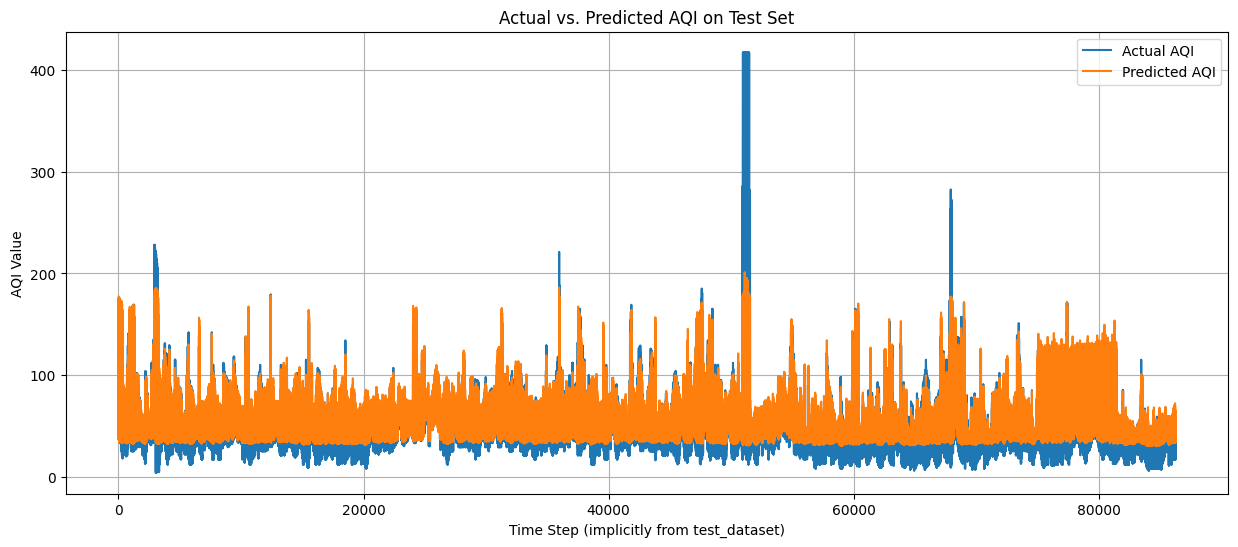

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs. Predicted AQI on Test Set')
plt.xlabel('Time Step (implicitly from test_dataset)')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('vmd_cnn_lstm_model.h5')
print("Model saved successfully as 'vmd_cnn_lstm_model.h5'")

Model saved successfully as 'vmd_cnn_lstm_model.h5'


In [1]:
# Epoch 1/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 361s 17ms/step - loss: 0.1178 - mae: 0.1805 - mape: 112.0434 - mse: 0.1178 - msle: 0.0194 - r2_keras: -3.0828 - rmse: 0.3374 - rmsle_custom: 0.0524 - val_loss: 0.0154 - val_mae: 0.0993 - val_mape: 85.4100 - val_mse: 0.0154 - val_msle: 0.0025 - val_r2_keras: 0.1899 - val_rmse: 0.1241 - val_rmsle_custom: 0.0320 - learning_rate: 0.0010
# Epoch 2/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 350s 16ms/step - loss: 0.0150 - mae: 0.0641 - mape: 41.3404 - mse: 0.0150 - msle: 0.0019 - r2_keras: 0.4355 - rmse: 0.1208 - rmsle_custom: 0.0177 - val_loss: 0.0127 - val_mae: 0.0923 - val_mape: 76.7561 - val_mse: 0.0127 - val_msle: 0.0026 - val_r2_keras: 0.3535 - val_rmse: 0.1126 - val_rmsle_custom: 0.0322 - learning_rate: 0.0010
# Epoch 3/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 360s 17ms/step - loss: 0.0080 - mae: 0.0500 - mape: 34.2882 - mse: 0.0080 - msle: 9.6168e-04 - r2_keras: 0.6051 - rmse: 0.0884 - rmsle_custom: 0.0136 - val_loss: 0.0379 - val_mae: 0.1663 - val_mape: 135.2689 - val_mse: 0.0379 - val_msle: 0.0066 - val_r2_keras: -1.1163 - val_rmse: 0.1947 - val_rmsle_custom: 0.0500 - learning_rate: 0.0010
# Epoch 4/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 356s 17ms/step - loss: 0.0083 - mae: 0.0480 - mape: 33.1183 - mse: 0.0083 - msle: 0.0011 - r2_keras: 0.6059 - rmse: 0.0904 - rmsle_custom: 0.0130 - val_loss: 0.0165 - val_mae: 0.1123 - val_mape: 91.9006 - val_mse: 0.0165 - val_msle: 0.0026 - val_r2_keras: 0.0327 - val_rmse: 0.1285 - val_rmsle_custom: 0.0314 - learning_rate: 0.0010
# Epoch 5/50
# 21419/21421 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - mae: 0.0428 - mape: 31.5194 - mse: 0.0058 - msle: 7.4642e-04 - r2_keras: 0.6858 - rmse: 0.0757 - rmsle_custom: 0.0116
# Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 349s 16ms/step - loss: 0.0058 - mae: 0.0428 - mape: 31.5193 - mse: 0.0058 - msle: 7.4642e-04 - r2_keras: 0.6858 - rmse: 0.0757 - rmsle_custom: 0.0116 - val_loss: 0.0183 - val_mae: 0.1210 - val_mape: 91.5684 - val_mse: 0.0183 - val_msle: 0.0020 - val_r2_keras: -0.1053 - val_rmse: 0.1354 - val_rmsle_custom: 0.0280 - learning_rate: 0.0010
# Epoch 6/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 351s 16ms/step - loss: 0.0041 - mae: 0.0340 - mape: 25.1453 - mse: 0.0041 - msle: 5.3251e-04 - r2_keras: 0.8377 - rmse: 0.0635 - rmsle_custom: 0.0095 - val_loss: 0.0186 - val_mae: 0.1222 - val_mape: 83.7127 - val_mse: 0.0186 - val_msle: 0.0017 - val_r2_keras: -0.1554 - val_rmse: 0.1366 - val_rmsle_custom: 0.0260 - learning_rate: 5.0000e-04
# Epoch 7/50
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 350s 16ms/step - loss: 0.0030 - mae: 0.0316 - mape: 23.9971 - mse: 0.0030 - msle: 3.8088e-04 - r2_keras: 0.8549 - rmse: 0.0544 - rmsle_custom: 0.0087 - val_loss: 0.0202 - val_mae: 0.1288 - val_mape: 84.3967 - val_mse: 0.0202 - val_msle: 0.0015 - val_r2_keras: -0.3177 - val_rmse: 0.1421 - val_rmsle_custom: 0.0249 - learning_rate: 5.0000e-04
# Epoch 8/50
# 21419/21421 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - mae: 0.0300 - mape: 23.0584 - mse: 0.0025 - msle: 3.2510e-04 - r2_keras: 0.8632 - rmse: 0.0497 - rmsle_custom: 0.0082
# Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
# 21421/21421 ━━━━━━━━━━━━━━━━━━━━ 387s 17ms/step - loss: 0.0025 - mae: 0.0300 - mape: 23.0584 - mse: 0.0025 - msle: 3.2510e-04 - r2_keras: 0.8631 - rmse: 0.0497 - rmsle_custom: 0.0082 - val_loss: 0.0213 - val_mae: 0.1323 - val_mape: 85.7751 - val_mse: 0.0213 - val_msle: 0.0015 - val_r2_keras: -0.4162 - val_rmse: 0.1459 - val_rmsle_custom: 0.0251 - learning_rate: 5.0000e-04

NameError: name 'hist' is not defined